# Physics Informed Neural Network(PINN) for Ball Trajectory Using PyTorch

This notebook demonstrates a Physics-Informed Neural Network (PINN)
for predicting the trajectory of a ball under gravity. I start by
building a simple MLP model, generate synthetic data based on the
analytical solution of the ball's motion, define multiple loss functions
(data, ODE, and initial condition), and then train the model under
different loss weight configurations

### 1. Import Required Libraries

In [101]:
import torch
import torch.nn as nn
import numpy as np
import matplotlib.pyplot as plt


### 2. Define the PINN Model

In [102]:
class PINN(nn.Module):
  def __init__(self,n_hidden=20):
    super(PINN,self).__init__()
    # A simple MLP with 2 hidden layers
    self.net=nn.Sequential(
      nn.Linear(1,n_hidden),
      nn.Tanh(),
      nn.Linear(n_hidden,n_hidden),
      nn.Tanh(),
      nn.Linear(n_hidden,1)
    )
  def forward(self,t):
    return self.net(t)

# Initialize the model with 20 neurons in each hidden layer
model=PINN(n_hidden=20)

### 3. Generate Synthetic Data Based on the Physics Model

In [103]:
# Physics parameters
g=9.8   # accelaration due to gravity in (m/s^2)
h0=1.0  # initial height in (m)
v0=10.0   # initial velocity in (m/s)

In [104]:
# True (analytical) solution  h(t) = h0 + v0 * t - 0.5 * g * t^2
def true_solution(t):
  return h0 +  v0 * t - 0.5 * g * (t**2)

In [105]:
# Generate some time points
t_min, t_max=0.0,2.0
n_data=10
t_data=np.linspace(t_min,t_max,n_data)

In [106]:
# Generate synthetic experimental heights with noise
np.random.seed(0)   # For reproducibility
noise_level=0.7
h_data_exact=true_solution(t_data)
h_data_noisy=h_data_exact + noise_level * np.random.randn(n_data)

In [107]:
# Convert to pytorch tensors
t_data_tensors=torch.tensor(t_data,dtype=torch.float32).view(-1,1)  # inputs
h_data_tensors=torch.tensor(h_data_noisy,dtype=torch.float32).view(-1,1)  #outputs

### 4. Define Helper Function for Automatic Differentiation

In [108]:
# Helper for automatic diff
def derivative(y,x):
  # compute dy/dx using pytorch's autograd, y and x must be tensors with requires_grad=True for x
  return torch.autograd.grad(y,x,grad_outputs=torch.ones_like(y),create_graph=True)[0]

### 5. Define Loss Functions for the PINN

In [109]:
# Define the loss components (PINN)
# (1) Data loss (fit noisy data)
# (2) Ordinary Differential Equation(ODE) loss: dh/dt = v0 - g *t
# (3) Initial contition(IC) loss: h(0) = h0

def physics_loss(model,t):
  # compare d(h_pred)/dt with known expression (v0 - g * t)
  # t must have required_grad = True for autograd to work
  t.requires_grad_(True)
  h_pred=model(t)
  dh_dt_pred=derivative(h_pred,t)

  #for each t, physics say dh/dt = v0 - g *t
  dh_dt_true=v0-g*t
  loss_ode=torch.mean((dh_dt_pred-dh_dt_true)**2)
  return loss_ode

def initial_condition_loss(model):
  # enforce h(0) = h0
  # evaluate at t=0
  t0=torch.zeros(1,1,dtype=torch.float32,requires_grad=False)
  h0_pred=model(t0)
  return (h0_pred-h0).pow(2).mean()

def data_loss(model,t_data,h_data):
  # Mean Squared Error(MSE) between predicted h(t_i) and noisy measurements h_data
  h_pred=model(t_data)
  loss_data=torch.mean((h_pred-h_data)**2)
  return loss_data

# 6. Training Setup and Regime 1: Full PINN (All Loss Terms)

In [110]:
# Training setup
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)

# hyper parameters for weighting the loss terms
# Use equal weightage for all loss components
lambda_data = 1.0
lambda_ode = 1.0
lambda_ic = 1.0

# for logging
num_epochs = 2000
print_every =200

In [88]:
# Training loop
model.train()
print("Training Regime 1: Full PINN (Data, ODE, and IC Loss)")

for i in range(num_epochs):
  optimizer.zero_grad()

  #compute losses
  l_data=data_loss(model,t_data_tensors,h_data_tensors)
  l_ode=physics_loss(model,t_data_tensors)
  l_ic=initial_condition_loss(model)

  #combine loss
  loss=lambda_data * l_data + lambda_ode * l_ode + lambda_ic * l_ic

  # BackPropagation
  loss.backward()
  optimizer.step()

  # Logging
  if (i+1) % print_every == 0:
    print(f"Epoch [{i+1}/{num_epochs}], Total Loss: {loss.item():.4f}, Data Loss: {l_data.item():.4f}, ODE Loss: {l_ode.item():.4f}, IC Loss: {l_ic.item():.4f}")

Training Regime 1: Full PINN (Data, ODE, and IC Loss)
Epoch [200/2000], Total Loss: 21.8703, Data Loss: 3.0791, ODE Loss: 18.7907, IC Loss: 0.0004
Epoch [400/2000], Total Loss: 21.7382, Data Loss: 3.0390, ODE Loss: 18.6989, IC Loss: 0.0003
Epoch [600/2000], Total Loss: 21.5794, Data Loss: 2.9027, ODE Loss: 18.6741, IC Loss: 0.0026
Epoch [800/2000], Total Loss: 21.4827, Data Loss: 2.8074, ODE Loss: 18.6629, IC Loss: 0.0124
Epoch [1000/2000], Total Loss: 21.4513, Data Loss: 2.7768, ODE Loss: 18.6618, IC Loss: 0.0127
Epoch [1200/2000], Total Loss: 2.7315, Data Loss: 0.7542, ODE Loss: 1.9580, IC Loss: 0.0194
Epoch [1400/2000], Total Loss: 0.8295, Data Loss: 0.4816, ODE Loss: 0.3358, IC Loss: 0.0121
Epoch [1600/2000], Total Loss: 0.5584, Data Loss: 0.4387, ODE Loss: 0.1071, IC Loss: 0.0126
Epoch [1800/2000], Total Loss: 0.4735, Data Loss: 0.3945, ODE Loss: 0.0663, IC Loss: 0.0128
Epoch [2000/2000], Total Loss: 0.4264, Data Loss: 0.3853, ODE Loss: 0.0282, IC Loss: 0.0128


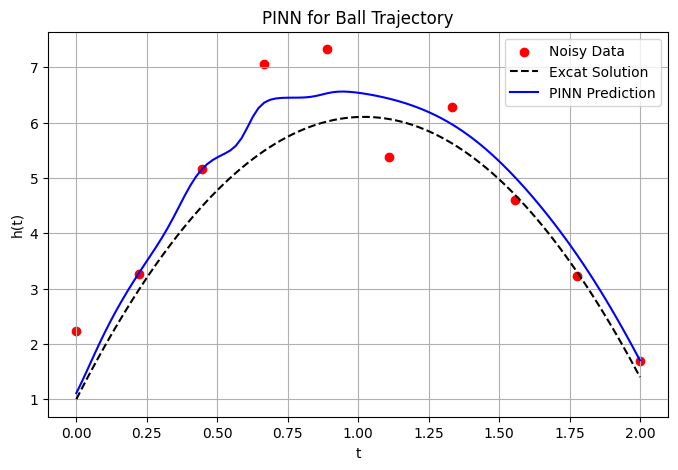

In [89]:
# Evaluate and plot results for Regime 1
t_plot = np.linspace(t_min,t_max,100).reshape(-1,1).astype(np.float32)
t_plot_tensor=torch.tensor(t_plot,requires_grad=True)
h_pred_plot=model(t_plot_tensor).detach().numpy()

# True solution (for comparison)
h_true_plot=true_solution(t_plot)

# plot results
plt.figure(figsize=(8,5))
plt.scatter(t_data,h_data_noisy,color='red',label='Noisy Data')
plt.plot(t_plot,h_true_plot,'k--',label='Excat Solution')
plt.plot(t_plot,h_pred_plot,'b',label='PINN Prediction')
plt.xlabel('t')
plt.ylabel('h(t)')
plt.legend()
plt.title('PINN for Ball Trajectory')
plt.grid(True)
plt.show()



### 7. Training Regime 2: Data-Only Loss (No PINN)

In [90]:
# Reinitialize optimizer (if needed) and adjust loss weights
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)

# hyper parameters for weighting the loss terms
# Only data loss is considered (physics loss and initial condition loss are ignored).
lambda_data = 20.0
lambda_ode = 0.0
lambda_ic = 0.0

# for logging
num_epochs = 2000
print_every =200

# Training loop
model.train()
print("Training Regime 2: Data-Only Loss (No PINN)")


for i in range(num_epochs):
  optimizer.zero_grad()

  #compute losses
  l_data=data_loss(model,t_data_tensors,h_data_tensors)
  l_ode=physics_loss(model,t_data_tensors)
  l_ic=initial_condition_loss(model)

  #combine loss
  loss=lambda_data * l_data + lambda_ode * l_ode + lambda_ic * l_ic

  # BackPropagation
  loss.backward()
  optimizer.step()

  # Logging
  if (i+1) % print_every == 0:
    print(f"Epoch [{i+1}/{num_epochs}], Total Loss: {loss.item():.4f}, Data Loss: {l_data.item():.4f}, ODE Loss: {l_ode.item():.4f}, IC Loss: {l_ic.item():.4f}")




Training Regime 2: Data-Only Loss (No PINN)
Epoch [200/2000], Total Loss: 2.4118, Data Loss: 0.1206, ODE Loss: 18.4744, IC Loss: 1.5146
Epoch [400/2000], Total Loss: 1.7784, Data Loss: 0.0889, ODE Loss: 25.9547, IC Loss: 1.5256
Epoch [600/2000], Total Loss: 0.0765, Data Loss: 0.0038, ODE Loss: 21.6552, IC Loss: 1.5248
Epoch [800/2000], Total Loss: 0.0556, Data Loss: 0.0028, ODE Loss: 23.6358, IC Loss: 1.5249
Epoch [1000/2000], Total Loss: 0.0428, Data Loss: 0.0021, ODE Loss: 21.5380, IC Loss: 1.5249
Epoch [1200/2000], Total Loss: 0.0331, Data Loss: 0.0017, ODE Loss: 16.8576, IC Loss: 1.5207
Epoch [1400/2000], Total Loss: 0.0208, Data Loss: 0.0010, ODE Loss: 16.8220, IC Loss: 1.5246
Epoch [1600/2000], Total Loss: 0.1181, Data Loss: 0.0059, ODE Loss: 18.6266, IC Loss: 1.5007
Epoch [1800/2000], Total Loss: 0.0681, Data Loss: 0.0034, ODE Loss: 20.6124, IC Loss: 1.5063
Epoch [2000/2000], Total Loss: 0.6859, Data Loss: 0.0343, ODE Loss: 21.1509, IC Loss: 1.4631


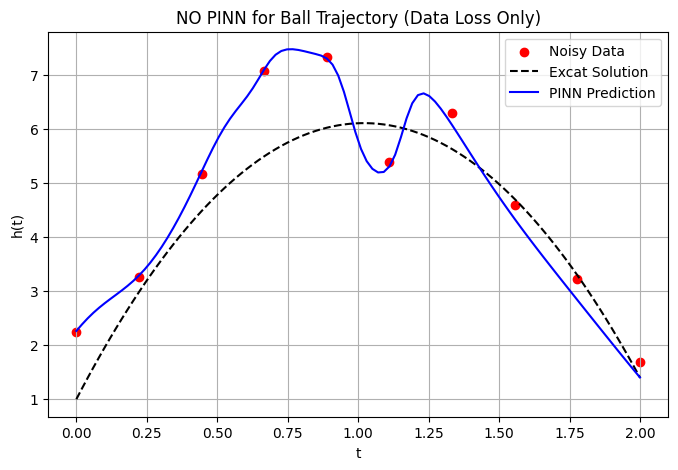

In [91]:
# Evaluate and plot results for Regime 2
t_plot = np.linspace(t_min,t_max,100).reshape(-1,1).astype(np.float32)
t_plot_tensor=torch.tensor(t_plot,requires_grad=True)
h_pred_plot=model(t_plot_tensor).detach().numpy()

# True solution (for comparison)
h_true_plot=true_solution(t_plot)

# plot results
plt.figure(figsize=(8,5))
plt.scatter(t_data,h_data_noisy,color='red',label='Noisy Data')
plt.plot(t_plot,h_true_plot,'k--',label='Excat Solution')
plt.plot(t_plot,h_pred_plot,'b',label='PINN Prediction')
plt.xlabel('t')
plt.ylabel('h(t)')
plt.legend()
plt.title('NO PINN for Ball Trajectory (Data Loss Only)')
plt.grid(True)
plt.show()



### 8. Training Regime 3: Physics-Only Loss (Data Loss Ignored)

In [111]:
# Reinitialize optimizer and adjust loss weights:
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)

# hyper parameters for weighting the loss terms
# Here, we only consider the physics (ODE) and initial condition losses.
lambda_data = 0.0
lambda_ode = 1.0
lambda_ic = 1.0

# for logging
num_epochs = 2000
print_every =200

# Training loop
model.train()
print("Training Regime 3: Physics-Only Loss (Data Loss Ignored)")

for i in range(num_epochs):
  optimizer.zero_grad()

  #compute losses
  l_data=data_loss(model,t_data_tensors,h_data_tensors)
  l_ode=physics_loss(model,t_data_tensors)
  l_ic=initial_condition_loss(model)

  #combine loss
  loss=lambda_data * l_data + lambda_ode * l_ode + lambda_ic * l_ic

  # BackPropagation
  loss.backward()
  optimizer.step()

  # Logging
  if (i+1) % print_every == 0:
    print(f"Epoch [{i+1}/{num_epochs}], Total Loss: {loss.item():.4f}, Data Loss: {l_data.item():.4f}, ODE Loss: {l_ode.item():.4f}, IC Loss: {l_ic.item():.4f}")

Training Regime 3: Physics-Only Loss (Data Loss Ignored)
Epoch [200/2000], Total Loss: 0.0008, Data Loss: 0.6350, ODE Loss: 0.0008, IC Loss: 0.0000
Epoch [400/2000], Total Loss: 0.0002, Data Loss: 0.6341, ODE Loss: 0.0002, IC Loss: 0.0000
Epoch [600/2000], Total Loss: 0.0001, Data Loss: 0.6397, ODE Loss: 0.0001, IC Loss: 0.0000
Epoch [800/2000], Total Loss: 0.0001, Data Loss: 0.6456, ODE Loss: 0.0001, IC Loss: 0.0000
Epoch [1000/2000], Total Loss: 0.0000, Data Loss: 0.6507, ODE Loss: 0.0000, IC Loss: 0.0000
Epoch [1200/2000], Total Loss: 0.0000, Data Loss: 0.6545, ODE Loss: 0.0000, IC Loss: 0.0000
Epoch [1400/2000], Total Loss: 0.0000, Data Loss: 0.6568, ODE Loss: 0.0000, IC Loss: 0.0000
Epoch [1600/2000], Total Loss: 0.0000, Data Loss: 0.6580, ODE Loss: 0.0000, IC Loss: 0.0000
Epoch [1800/2000], Total Loss: 0.0000, Data Loss: 0.6588, ODE Loss: 0.0000, IC Loss: 0.0000
Epoch [2000/2000], Total Loss: 0.0000, Data Loss: 0.6591, ODE Loss: 0.0000, IC Loss: 0.0000


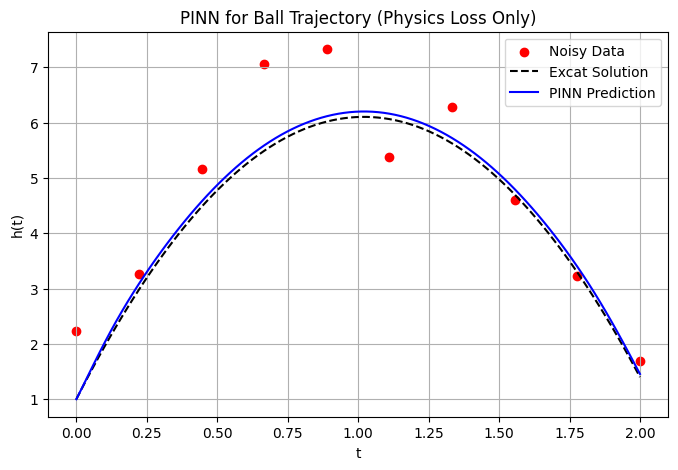

In [112]:
# Evaluate and plot results for Regime 3
t_plot = np.linspace(t_min,t_max,100).reshape(-1,1).astype(np.float32)
t_plot_tensor=torch.tensor(t_plot,requires_grad=True)
h_pred_plot=model(t_plot_tensor).detach().numpy()

# True solution (for comparison)
h_true_plot=true_solution(t_plot)

# plot results
plt.figure(figsize=(8,5))
plt.scatter(t_data,h_data_noisy,color='red',label='Noisy Data')
plt.plot(t_plot,h_true_plot,'k--',label='Excat Solution')
plt.plot(t_plot,h_pred_plot,'b',label='PINN Prediction')
plt.xlabel('t')
plt.ylabel('h(t)')
plt.legend()
plt.title('PINN for Ball Trajectory (Physics Loss Only)')
plt.grid(True)
plt.show()

# Summary

The code demonstrates that a Physics-Informed Neural Network (PINN) trained with a **physics-only loss** can effectively model a ball's trajectory even when the experimental data is noisy.

## Key Points

- **Physics-Based Constraints**:  
  Instead of relying on the noisy data, the training leverages the underlying physics by enforcing the differential equation:

  $$
  \frac{dh}{dt} = v_0 - g \, t
  $$

  and the initial condition:

  $$
  h(0) = h_0
  $$

  These constraints guide the network toward learning the true dynamics of the system.

- **Robustness Against Noise**:  
  By focusing solely on the physics loss, the model is less influenced by the noisy measurements, enabling it to converge toward the correct trajectory even with imperfect data.

- **Accurate Prediction**:  
  The PINN's prediction closely aligns with the analytical solution of the ball's trajectory, demonstrating that incorporating physical laws into the training process can lead to improved generalization and accuracy.

- **Visualization**:  
  The plotted results confirm that the network's output accurately replicates the expected behavior dictated by the underlying physics, validating the effectiveness of the physics-only training approach.

Overall, this approach highlights the power of integrating physical laws into neural network training, particularly when dealing with noisy or unreliable data.
